# E04

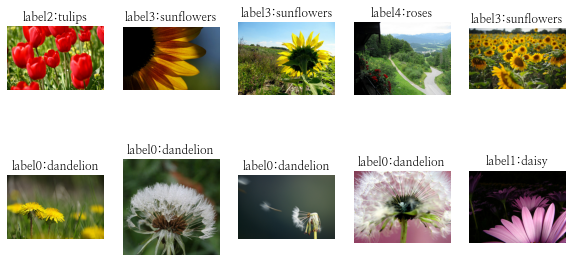

In [27]:
import warnings
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

warnings.filterwarnings("ignore")
# print(tf.__version__)
# print(tfds.__version__)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# print(raw_train)
# print(raw_validation)
# print(raw_test)
# 이미지는 (None, None, 3)의 shape를 가진다. 3은 이미지가 컬러이므로

# 데이터를 시각화하고 모델에서 사용할 수 있는 형태로 전처리 하기
import matplotlib.pyplot as plt
# 주피터 노트북 사용시 브라우저에 그림을 보여주기 위해
%matplotlib inline    
%config inlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))
get_label_name = metadata.features['label'].int2str

# tf.data.Dataset에서 제공하는 take함수로서, 인수만큼의 데이터를 추출하여
# 새로운 데이터셋 인스턴스 생성
for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image)
    plt.title(f'label{label}:{get_label_name(label)}')
    plt.axis('off')

Epoch 1/40
92/92 [==============================] - 29s 310ms/step - loss: 1.1689 - accuracy: 0.6233 - val_loss: 0.9015 - val_accuracy: 0.7302
Epoch 2/40
92/92 [==============================] - 7s 75ms/step - loss: 0.8194 - accuracy: 0.7493 - val_loss: 0.7472 - val_accuracy: 0.7602
Epoch 3/40
92/92 [==============================] - 7s 75ms/step - loss: 0.6799 - accuracy: 0.7796 - val_loss: 0.6465 - val_accuracy: 0.7793
Epoch 4/40
92/92 [==============================] - 7s 75ms/step - loss: 0.6053 - accuracy: 0.8065 - val_loss: 0.5897 - val_accuracy: 0.7902
Epoch 5/40
92/92 [==============================] - 7s 75ms/step - loss: 0.5569 - accuracy: 0.8178 - val_loss: 0.5945 - val_accuracy: 0.7738
Epoch 6/40
92/92 [==============================] - 7s 75ms/step - loss: 0.5226 - accuracy: 0.8263 - val_loss: 0.5326 - val_accuracy: 0.8202
Epoch 7/40
92/92 [==============================] - 7s 76ms/step - loss: 0.4919 - accuracy: 0.8355 - val_loss: 0.5162 - val_accuracy: 0.8202
Epoch 8/40


<Figure size 720x360 with 0 Axes>

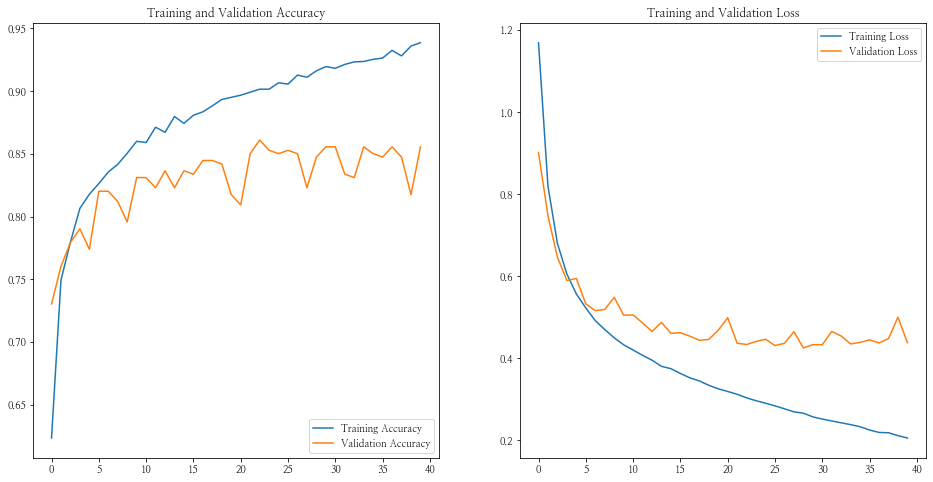

In [1]:



# 이미지 사이즈 통일시키기 작업
IMG_SIZE = 160


def format_example(image, label):
    image = tf.cast(image, tf.float32)  # tensorflow에서 타입 캐스팅하는 방법
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label


train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# 기존에 잘 학습된 모델 가져오기(VGG16)
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

# base_model.summary()    # VGG16 모델 구조

# Global Average Pooling계층 만들기
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Dense레이어 추가하기
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# 잘 학습된 모델이 있으므로 이 모델은 학습시키지 않습니다.
base_model.trainable = False

# 최종 모델
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

# model 구조 확인하기
# model.summary()

# 모델은 한 장의 이미지를 여러 레이어를 거쳐서 데이터를 집약하여 확률로 만들어낸다.

# 데이터를 학습시키기
base_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
# optimizer -> 학습을 최적화시키는 함수
# loss -> 모델이 학습해야할 방향, 고양이일 확률과 강아지일 확률을 출력하므로
#         [0.0, 1.0] label = 1인 경우
# metrics -> 모델 성능 평가

# 한 스텝에 학습시킬 데이터 개수와 데이터를 섞어줄 변수 설정
BATCH_SIZE = 32     # 한 번 돌 때마다 32개의 데이터를 학습한다.
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# train_batches에 있는 데이터 확인
# for image_batch, label_batch in train_batches.take(1):
#     pass
# print(image_batch.shape, label_batch.shape)

# 학습 전 모델의 성능 평가
# validation_steps = 20
# loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

# 모델 학습시키기
EPOCHS = 40
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

# accuracy, val_accuracy 변화 그래프 확인
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 예측 결과 확인해보기
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass
#
# print(predictions)  # 확률로 저장이 됨
# predictions = np.argmax(predictions, axis=1)    # 실제 분류한 값 0, 1

# 예측값을 이미지로 비교하기
# plt.figure(figsize=(20, 12))
#
# for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
#     plt.subplot(4, 8, idx+1)
#     image = (image + 1) / 2
#     plt.imshow(image)
#     correct = label == prediction
#     title = f'real: {label} / pred :{prediction}\n {correct}!'
#     if not correct:
#         plt.title(title, fontdict={'color': 'red'})
#     else:
#         plt.title(title, fontdict={'color': 'blue'})
#     plt.axis('off')




EPOCH = 05인 경우 val_accuracy = 0.7766   
EPOCH = 10인 경우 val_accuracy = 0.8065   
EPOCH = 15인 경우 val_accuracy = 0.8202   
EPOCH = 30인 경우 val_accuracy = 0.8392   
EPOCH = 40인 경우 val_accuracy = 0.8501   
EPOCH = 50인 경우 val_accuracy = 0.8529   
accuracy가 변화량이 매우 적어 더 이상 Epoch = 40에서 다시 조정한다.   

learning rate = 0.0002로 변경 val_accuracy = 0.8556   
learning rate 조정은 큰 변화가 없다.



In [34]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass
#
print(predictions)  # 확률로 저장이 됨
predictions = np.argmax(predictions, axis=1)   # 실제 분류한 값 0, 1
print(predictions)

[[9.21829371e-04 3.59762483e-03 9.49968338e-01 2.93282582e-03
  4.25793566e-02]
 [9.99991894e-01 8.01609713e-06 1.26876920e-09 3.04789616e-08
  1.70992607e-07]
 [7.02037871e-01 1.24085777e-01 9.18623898e-03 1.57135576e-01
  7.55452085e-03]
 [4.05372593e-05 2.31777740e-04 6.15088105e-01 6.64787221e-05
  3.84573042e-01]
 [8.35958958e-01 1.58236399e-01 1.23163732e-03 2.32991506e-03
  2.24308809e-03]
 [9.89165723e-01 8.11153650e-03 2.29285331e-04 2.47071357e-03
  2.27118962e-05]
 [6.23588683e-04 1.13879163e-04 9.89990234e-01 5.49751474e-03
  3.77470232e-03]
 [2.40071192e-01 7.55430758e-01 1.95430857e-05 4.34955256e-03
  1.28929518e-04]
 [3.00894433e-04 1.12154003e-05 2.75083468e-03 9.93164837e-01
  3.77233070e-03]
 [9.99966145e-01 3.35747172e-05 7.58823937e-09 2.15462975e-07
  3.23853655e-08]
 [9.90474284e-01 8.90711695e-03 2.96102080e-05 5.81212051e-04
  7.77114383e-06]
 [7.69915283e-01 1.15829706e-03 5.89701757e-02 1.68568403e-01
  1.38780137e-03]
 [2.96304771e-03 4.60280426e-04 9.175547

In [41]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img_dir_path = os.getenv("HOME") + "/aiffel/flower"
    
IMG_SIZE = 160
flower_image_path = os.path.join(img_dir_path, 'sunflower.jpeg')
flower_image = load_img(flower_image_path, target_size=(IMG_SIZE, IMG_SIZE))
flower_image = img_to_array(flower_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
prediction = model.predict(flower_image)

print(prediction)



[[0.0000000e+00 1.7723007e-12 0.0000000e+00 1.0000000e+00 0.0000000e+00]]


해바라기 예측함.